# Finance Data Analysis Project using yfinance

**Author**: Sohila Khaled Abbas

**Purpose**: A software-engineering-minded Jupyter-style notebook (Python script with cells) that
- loads configuration
- fetches price data from yfinance
- validates and engineers features
- saves artifacts for Power BI
- includes reproducible pipeline structure, logging, and simple tests

**Instructions:**
- Run this file in a Jupyter environment or run cells in VS Code/Colab. Cells are separated by `# %%` markers.
- Install dependencies from requirements cell below.

In [1]:
# Requirements
# pip install yfinance pandas numpy pyarrow matplotlib pytest python-dateutil

In [2]:
"""Config and imports"""
from dataclasses import dataclass
from typing import List, Optional
import logging
import os
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

In [3]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class Config:
    tickers: List[str]
    start_date: str
    end_date: str
    interval: str = '1d'  # '1d', '1m', '1h', etc.
    data_dir: str = 'data'
    overwrite: bool = False

In [4]:
# default config (example)
cfg = Config(
    tickers=['AAPL', 'MSFT', 'GOOGL'],
    start_date=(datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d'),
    end_date=datetime.today().strftime('%Y-%m-%d'),
    interval='1d',
    data_dir='data',
)

os.makedirs(cfg.data_dir, exist_ok=True)
logger.info(f"Data directory: {cfg.data_dir}")

2025-10-04 12:51:06,997 INFO Data directory: data


## Helper functions (software-engineering oriented)

In [5]:
def fetch_history(tickers: List[str], start: str, end: str, interval: str = '1d') -> pd.DataFrame:
    """Fetch historical price data for a list of tickers using yfinance.
    Returns a tidy DataFrame with ticker as a column.
    """
    logger.info(f"Fetching data for {len(tickers)} tickers from {start} to {end} interval={interval}")
    # yfinance supports multi-ticker download
    data = yf.download(tickers, start=start, end=end, interval=interval, group_by='ticker', auto_adjust=False, threads=True, progress=False)

    # If single ticker, yfinance returns single-level columns
    if len(tickers) == 1:
        t = tickers[0]
        df = data.copy()
        df.columns = pd.MultiIndex.from_product([[t], df.columns])
    else:
        df = data

    # Convert to tidy long format: Date, Ticker, Open, High, Low, Close, Adj Close, Volume
    records = []
    for t in tickers:
        if (t, 'Close') not in df.columns:
            logger.warning(f"Ticker {t} missing in downloaded data; skipping")
            continue
        sub = df[t].copy()
        sub['Ticker'] = t
        sub = sub.reset_index()
        records.append(sub)
    if not records:
        raise RuntimeError('No data fetched for requested tickers')
    out = pd.concat(records, axis=0, ignore_index=True)
    out = out[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return out

In [6]:
def validate_prices(df: pd.DataFrame) -> pd.DataFrame:
    """Basic validation of price DataFrame.
    - Ensure no negative prices
    - Check missing dates per ticker and report gaps
    """
    df = df.copy()
    if (df[['Open','High','Low','Close','Adj Close']] < 0).any().any():
        raise ValueError('Negative prices found')

    # Check for duplicates
    dup = df.duplicated(subset=['Date','Ticker']).sum()
    if dup > 0:
        logger.warning(f"Found {dup} duplicated rows — deduplicating")
        df = df.drop_duplicates(subset=['Date','Ticker'])

    # Report gaps
    gap_report = []
    for t, group in df.groupby('Ticker'):
        group = group.set_index('Date').sort_index()
        expected = pd.date_range(group.index.min(), group.index.max(), freq='D')
        missing = expected.difference(group.index.normalize())
        if len(missing) > 0:
            gap_report.append((t, len(missing), missing[:3].tolist()))
    if gap_report:
        logger.info('Gaps detected for tickers:')
        for item in gap_report:
            logger.info(f"Ticker={item[0]} missing_days={item[1]} example={item[2]}")
    return df

In [7]:
def compute_technical_indicators(df: pd.DataFrame, windows: Optional[List[int]] = None) -> pd.DataFrame:
    """Compute common technical indicators: returns, moving averages, volatility (rolling std).
    Expects tidy DataFrame with Date, Ticker, Close columns.
    """
    if windows is None:
        windows = [5, 20, 50]
    df = df.copy()
    df = df.sort_values(['Ticker','Date'])
    df['Return'] = df.groupby('Ticker')['Adj Close'].pct_change()
    for w in windows:
        df[f'SMA_{w}'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(w).mean())
        df[f'Vol_{w}'] = df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(w).std())
    # Daily log returns
    df['LogReturn'] = np.log(df['Adj Close']) - np.log(df.groupby('Ticker')['Adj Close'].shift(1))
    return df

In [8]:
def resample_to_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """Resample daily data to weekly OHLCV per ticker (W-FRI)"""
    out_frames = []
    for t, g in df.groupby('Ticker'):
        temp = g.set_index('Date').sort_index()
        o = temp['Open'].resample('W-FRI').first()
        h = temp['High'].resample('W-FRI').max()
        l = temp['Low'].resample('W-FRI').min()
        c = temp['Close'].resample('W-FRI').last()
        v = temp['Volume'].resample('W-FRI').sum()
        adj = temp['Adj Close'].resample('W-FRI').last()
        wdf = pd.DataFrame({'Open':o,'High':h,'Low':l,'Close':c,'Adj Close':adj,'Volume':v})
        wdf = wdf.reset_index()
        wdf['Ticker'] = t
        out_frames.append(wdf)
    return pd.concat(out_frames, ignore_index=True)

In [9]:
def save_artifacts(df: pd.DataFrame, cfg: Config):
    """Save a cleaned dataframe and aggregated versions for Power BI consumption."""
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    clean_path = os.path.join(cfg.data_dir, f'prices_clean_{ts}.parquet')
    df.to_parquet(clean_path, index=False)
    logger.info(f"Saved cleaned parquet to {clean_path}")

    # also CSV export for Power BI
    csv_path = os.path.join(cfg.data_dir, f'prices_clean_{ts}.csv')
    df.to_csv(csv_path, index=False)
    logger.info(f"Saved cleaned csv to {csv_path}")

    # create and save weekly resample
    weekly = resample_to_weekly(df)
    weekly_path = os.path.join(cfg.data_dir, f'prices_weekly_{ts}.parquet')
    weekly.to_parquet(weekly_path, index=False)
    logger.info(f"Saved weekly parquet to {weekly_path}")

    return {'parquet': clean_path, 'csv': csv_path, 'weekly_parquet': weekly_path}

## Pipeline: end-to-end example run

In [10]:
def run_pipeline(cfg: Config):
    df_raw = fetch_history(cfg.tickers, cfg.start_date, cfg.end_date, cfg.interval)
    df_valid = validate_prices(df_raw)
    df_features = compute_technical_indicators(df_valid)
    artifacts = save_artifacts(df_features, cfg)
    return df_features, artifacts

In [11]:
if __name__ == '__main__':
    logger.info('Running pipeline with default config')
    df, artifacts = run_pipeline(cfg)
    logger.info('Pipeline finished')

2025-10-04 12:51:07,071 INFO Running pipeline with default config
2025-10-04 12:51:07,072 INFO Fetching data for 3 tickers from 2024-10-04 to 2025-10-04 interval=1d
2025-10-04 12:51:07,072 INFO Fetching data for 3 tickers from 2024-10-04 to 2025-10-04 interval=1d
2025-10-04 12:51:11,947 INFO Gaps detected for tickers:
2025-10-04 12:51:11,948 INFO Ticker=AAPL missing_days=115 example=[Timestamp('2024-10-05 00:00:00'), Timestamp('2024-10-06 00:00:00'), Timestamp('2024-10-12 00:00:00')]
2025-10-04 12:51:11,949 INFO Ticker=GOOGL missing_days=115 example=[Timestamp('2024-10-05 00:00:00'), Timestamp('2024-10-06 00:00:00'), Timestamp('2024-10-12 00:00:00')]
2025-10-04 12:51:11,949 INFO Ticker=MSFT missing_days=115 example=[Timestamp('2024-10-05 00:00:00'), Timestamp('2024-10-06 00:00:00'), Timestamp('2024-10-12 00:00:00')]
2025-10-04 12:51:13,000 INFO Saved cleaned parquet to data\prices_clean_20251004_125112.parquet
2025-10-04 12:51:13,036 INFO Saved cleaned csv to data\prices_clean_20251004

## Quick Visualizations (optional)

In [12]:
import matplotlib.pyplot as plt

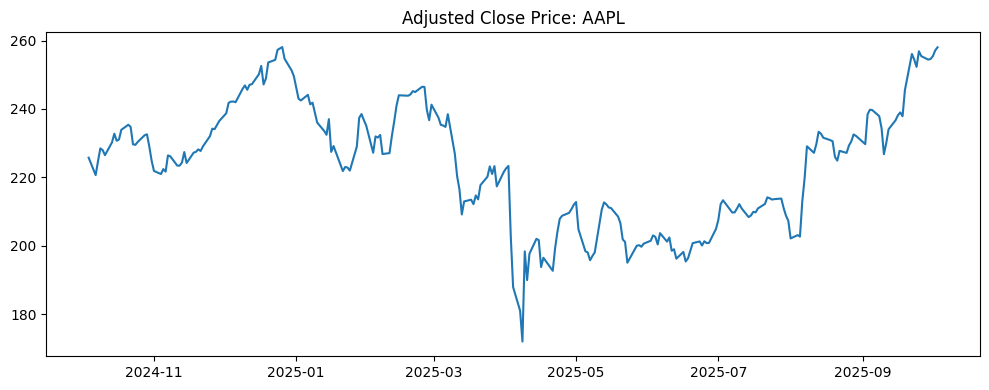

In [17]:
# sample plot function
def plot_close(ticker: str, df: pd.DataFrame):
    sub = df[df['Ticker'] == ticker].set_index('Date').sort_index()
    plt.figure(figsize=(10,4))
    plt.plot(sub['Adj Close'])
    plt.title(f'Adjusted Close Price: {ticker}')
    plt.tight_layout()
    plt.show()
# Example usage of plot function
plot_close('AAPL', df)        

## Unit-test-like sanity checks

In [14]:
def _sanity_tests(df: pd.DataFrame):
    # ensure at least one ticker present
    assert df['Ticker'].nunique() > 0, 'No tickers present'
    # no negative volumes
    assert (df['Volume'] >= 0).all(), 'Negative volume found'
    logger.info('Sanity tests passed')

In [15]:
# Example usage of tests (uncomment when running interactively)
# _sanity_tests(df)

## Data Pipeline Workflow

1. **Extract**: Use yfinance to pull stock/ETF data (tickers, OHLCV, fundamentals).
2. **Transform**: Engineer features:
     - Daily % returns
     - Rolling 30-day volatility
     - Moving averages (20, 50, 200-day)
     - Weekly resample for smoother trend visuals
3. **Load**: Save into a Data folder in CSV or Parquet → this is what Power BI connects to.

## Scheduled Refresh with Prefect (lightweight)

In [ ]:
from prefect import flow, task
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

@task
def fetch_data(tickers, start, end):
    return yf.download(tickers, start=start, end=end, group_by='ticker')

@task
def transform_data(raw_data):
    # Example: compute daily returns for each ticker
    frames = []
    for ticker in raw_data.columns.levels[0]:
        df = raw_data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Ticker'] = ticker
        frames.append(df)
    return pd.concat(frames)

@task
def save_data(df):
    df.to_parquet("data/finance_latest.parquet")

@flow
def finance_pipeline():
    tickers = ["AAPL", "MSFT", "GOOGL"]
    end = datetime.today()
    start = end - timedelta(days=365)
    raw = fetch_data(tickers, start, end)
    transformed = transform_data(raw)
    save_data(transformed)

if __name__ == "__main__":
    finance_pipeline()

➡️ Register this flow in **Prefect Cloud** or schedule it with cron (daily at 8am).

## Exporting for Power BI & Storytelling guidance

The pipeline saves `csv`/`parquet` artifacts in the `data/` folder. Use these files as the data source in Power BI.

### Suggested Power BI model & storytelling flow (high level):
1. Data model: single fact table (prices_clean) with dimensions created from the table: Date dimension (use Power BI's date table), Ticker dimension (Ticker + company metadata such as sector, market cap if you enrich), and Derived measures.
2. Important measures to create in Power BI (DAX):
   - Latest Close = LASTNONBLANKVALUE(prices[Adj Close], prices[Date])
   - Return (Period) = DIVIDE( SUM(prices[Adj Close]) - CALCULATE(SUM(prices[Adj Close]), DATEADD(DateTable[Date], -period, DAY)), CALCULATE(SUM(prices[Adj Close]), DATEADD(...)) )
   - Volatility (30-day) = calculate rolling stdev using DAX or precompute in Python.
3. Visuals and storytelling layout:
    - Top-level KPIs: Latest price, 1w/1m/1y returns, 30d volatility, market cap (if available).
    - Trend section: line chart of Adj Close with overlays of SMA_20 and SMA_50 + volume bars.
    - Return distribution: histogram or violin plot of daily returns.
    - Risk/Return scatter: x=Volatility (e.g., 30d), y=Return (e.g., YTD) with dots sized by market cap.
    - Event timeline: vertical lines or annotations for major events (earnings dates) — enrich data with corporate events if needed.
4. Narrative (storytelling):
    - Start with a one-sentence insight: e.g., "AAPL outperformed peers over the last year driven by X, while volatility rose in March due to Y."
    - Use sections: Summary (KPI), Evidence (charts), Drivers (tables + event annotations), Recommendations (actions or watchlist).
5. Interactivity: slicers for ticker, date range, and indicators. Bookmarks for scenario storytelling slides.


## Project Lifecycle
1. **Define audience** → Executive (storytelling KPIs) vs Quant (detailed stats).
2. **Design ETL pipeline in Python** → Prefect scheduled refresh.
3. **Export cleaned dataset** (Parquet/CSV).
4. **Connect to Power BI** → Build separate dashboards for each audience.
5. **Iterate & add context** (company metadata, sector benchmarks).
6. **Publish & Automate Refresh** → Power BI Service with same schedule as Prefect.